In [1]:
import os, errno

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline

import glambox as gb

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [3]:
make_sure_path_exists('examples/example_1/figures/')
make_sure_path_exists('examples/example_1/results/in_sample/traces/')
make_sure_path_exists('examples/example_1/results/in_sample/model_comparison/')
make_sure_path_exists('examples/example_1/results/out_of_sample/traces/')
make_sure_path_exists('examples/example_1/results/out_of_sample/predictions/')

# Example 1: Individual gaze biases

Our first example is based on the study by Thomas and colleagues (2019). Here, the authors study the association between gaze allocation and choice behaviour on the level of the individual. In particular, they explore whether (1) gaze biases are present on the individual level and (2) the strength of this association varies between individuals. In this example, we replicate this type of individual model-based analysis, including parameter estimation, comparison between multiple model variants, and out-of-sample prediction of choice and RT data.

### 1. Simulating data

First, we simulate a dataset containing 30 subjects, each performing 300 simple value-based choice trials. We assume that in each trial participants are asked to choose the item that they like most out of a set of three presented alternatives (e.g., snack food items; similar to the task described in Krajbich & Rangel (2011)). While participants perform the task, their eye movements, choices and RTs are measured. Before completing the choice trials, participants were asked to indicate their liking rating for each of the items used in the choice task on a liking rating scale between 1 and 10 (with 10 indicating strong liking and 1 indicating little liking). The resulting dataset contains a liking value for each item in a trial, the participants' choice and RT, as well as the participant's gaze towards each item in a trial (describing the fraction of trial time that the participant spent looking at each item in the choice set).

In [4]:
n_subjects = 30
subjects = np.arange(n_subjects)
n_trials = 300
n_items = 3

To simulate individuals' response behaviour, we utilize the parameter estimates that were obtained by Thomas et al. (2019) for the individuals in the three item choice dataset by Krajbich & Rangel (2011) (for an overview, see Fig. S1 of the manuscript). Importantly, we assume that 10 individuals do not exhibit a gaze bias, meaning that their choices are independent of the time that they spend looking at each item. To this end, we set the $\gamma$ value of ten randomly selected individuals to 1. We further assume that individuals' gaze is distributed randomly with respect to the values of the items in a choice set. 

In [5]:
np.random.seed(1)

# load empirical model parameters (taken from Thomas et al., 2019)
estimates = pd.read_csv('resources/individual_estimates_sec_nhb2019.csv')
kr2011 = estimates.loc[estimates['dataset'] == 'krajbich2011']
gen_parameters = dict(v=kr2011['v'].values,
                      gamma=kr2011['gamma'].values,
                      s=kr2011['s'].values,
                      tau=kr2011['tau'].values,
                      t0=np.zeros(len(kr2011)))

# define participants with no association between gaze and choice:
no_gaze_bias_subjects = np.sort(np.random.choice(n_subjects, 10, replace=False))
gaze_bias_subjects = np.array([s for s in subjects if s not in no_gaze_bias_subjects])
gen_parameters['gamma'][no_gaze_bias_subjects] = 1

The resulting distribution of generating model parameters looks as follows:

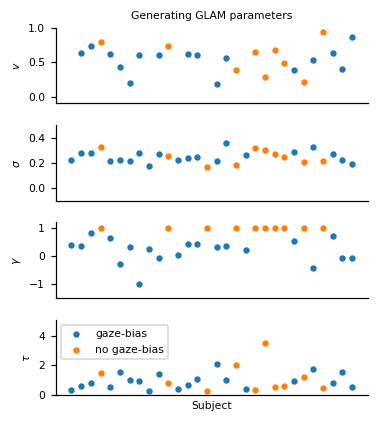

In [6]:
fig, axs = plt.subplots(4, 1, figsize=gb.plots._plots_internal.cm2inch(9,10), dpi=110, sharex=True)

for subject_set, color, label in zip([gaze_bias_subjects,
                                      no_gaze_bias_subjects],
                                      ['C0', 'C1'],
                                      ['gaze-bias', 'no gaze-bias']):
    # v
    axs[0].scatter(subject_set,
                   gen_parameters['v'][subject_set],
                   color=color,
                   s=10)
    axs[0].set_ylabel(r'$v$', fontsize=7)
    
    # sigma
    axs[1].scatter(subject_set,
                   gen_parameters['s'][subject_set],
                   color=color,
                   s=10)
    axs[1].set_ylabel(r'$\sigma$', fontsize=7)

    # gamma
    axs[2].scatter(subject_set,
                   gen_parameters['gamma'][subject_set],
                   color=color,
                   s=10)
    axs[2].set_ylabel(r'$\gamma$', fontsize=7)

    # tau
    axs[3].scatter(subject_set,
                   gen_parameters['tau'][subject_set],
                   color=color,
                   label=label,
                   s=10)
    axs[3].set_ylabel(r'$\tau$', fontsize=7)
    axs[3].set_xlabel('Subject', fontsize=7)
    

axs[0].set_title('Generating GLAM parameters', fontsize=7)
axs[0].set_ylim(-0.1, 1)
axs[1].set_ylim(-0.1, 0.5)
axs[2].set_ylim(-1.5, 1.2)
axs[3].set_ylim(0, 5.1)
axs[-1].legend(loc='upper left', frameon=True, fontsize=7)
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xticks([])
    
fig.tight_layout()
fig.savefig('examples/example_1/figures/Supplementary_Figure_1_generating_parameters.png', dpi=330)

These are the subjects that we defined as having no association of gaze allocation and choice behaviour:

In [7]:
no_gaze_bias_subjects

array([ 3, 10, 14, 17, 19, 20, 21, 22, 24, 26])

We first instantiate a GLAM model instance using `gb.GLAM()`and then use its `simulate_group` method. This method requires us to specify whether the individuals of the group are either simulated individually (and thereby independent of one another) or as part of a group with hierarchical parameter structure (where the individual model parameters are drawn from a group distribution, see below). For the former, the generating model parameters (indicated in the following as `gen_parameters`) are provided as a dictionary, containing a list of the individual participant values for each model parameter:

In [8]:
np.random.seed(2)

glam = gb.GLAM()
glam.simulate_group(kind='individual',
                    n_individuals=n_subjects,
                    n_trials=n_trials,
                    n_items=n_items,
                    parameters=gen_parameters,
                    value_range=(1, 10))

We can then access the simulated data as part of our GLAM model instance.

In [9]:
data = glam.data.copy()

In [10]:
data.head()

,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,condition
0,0.0,0.0,0.0,0.0,1.678472,9,0.649142,9,0.224745,7,0.126113,condition_0
1,0.0,1.0,0.0,2.0,1.307034,3,0.332040,9,0.312176,8,0.355783,condition_0
2,0.0,2.0,0.0,2.0,1.324605,3,0.423884,2,0.192437,6,0.383680,condition_0
3,0.0,3.0,0.0,1.0,1.145805,5,0.195771,5,0.454379,6,0.349851,condition_0
4,0.0,4.0,0.0,2.0,1.065713,8,0.209319,4,0.382790,7,0.407891,condition_0


As this example is focused on the individual level, we can further create a summary table, describing individuals' response behaviour on three behavioural metrics, using the `aggregate_subject_level_data` function from the `analysis` module. The resulting table contains individuals' mean RT, their probability of choosing the item with the highest item value from a choice set and a behavioural measure of the strength of the association between individuals' gaze allocation and choice behaviour (indicating the mean increase in choice probability for an item that was fixated on longer than the others, after correcting for the influence of the item value on choice behaviour; for further details, see Thomas et al. (2019)).

In [11]:
np.random.seed(3)

subject_data_summary = gb.analysis.aggregate_subject_level_data(data, n_items)

In [12]:
subject_data_summary.head()

rt                                                              \
             mean       std       min       max        se        q1        q3   
subject                                                                         
0.0      1.292315  0.477199  0.142598  4.708733  0.027597  1.025087  1.458560   
1.0      2.040758  0.878345  0.523410  6.317563  0.050796  1.413609  2.499227   
2.0      1.742749  0.720414  0.137617  4.912813  0.041663  1.261841  2.002483   
3.0      1.427180  0.697514  0.062293  5.375163  0.040338  0.967926  1.705945   
4.0      2.217397  0.755107  0.005503  4.586606  0.043669  1.662276  2.623872   

                  best_chosen gaze_influence  
              iqr        mean                 
subject                                       
0.0      0.433473    0.750000       0.189652  
1.0      1.085618    0.716667       0.202899  
2.0      0.740643    0.856667       0.033876  
3.0      0.738018    0.936667      -0.006805  
4.0      0.961595    0.850000       0.062939

### 2. Exploring the behavioural data

In a first step of our analysis, we explore differences in individuals' response behaviour. To this end, we plot the distributions of individuals' scores on the three behavioural metrics, and their associations, using the `plot_behaviour_associations` function implemented in the `plots` module:

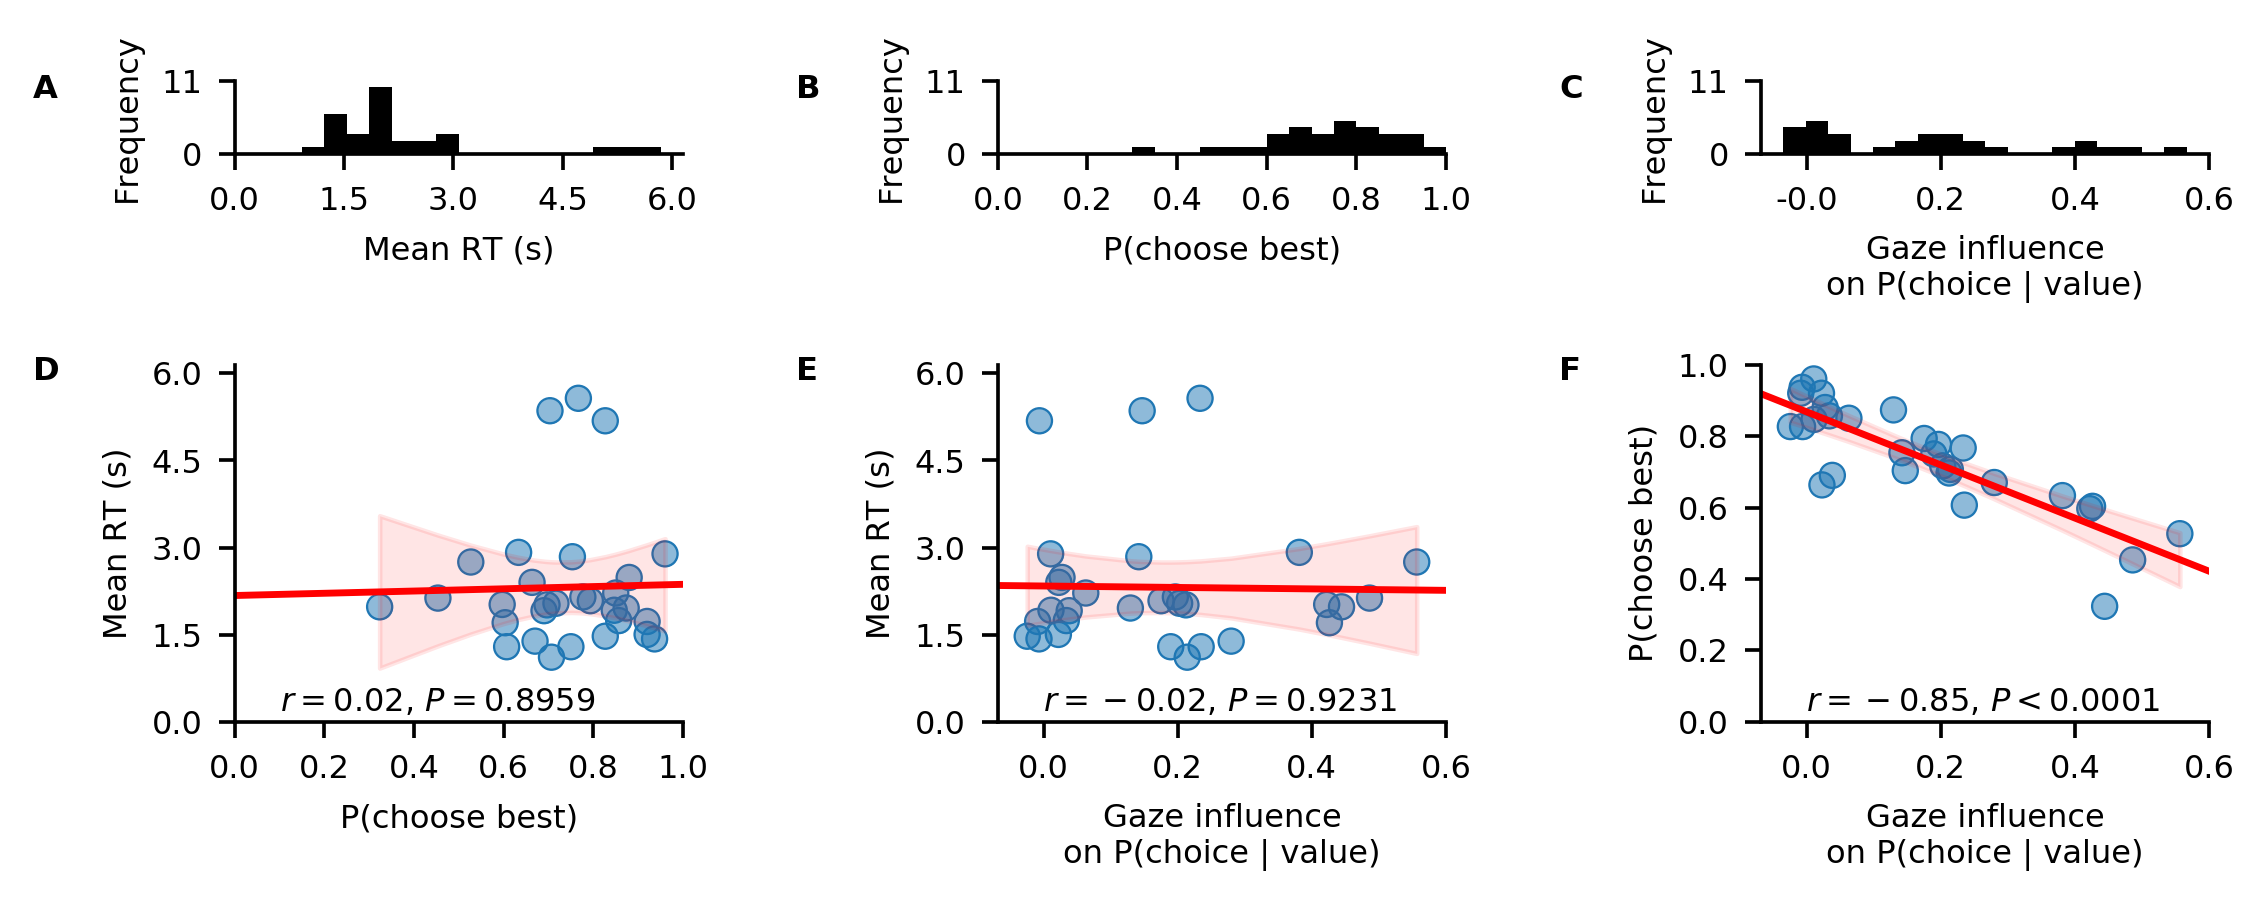

In [13]:
np.random.seed(4)

fig, axs = gb.plots.plot_behaviour_associations(data=data)

fig.savefig('examples/example_1/figures/Figure_1_individual_differences.png', dpi=330)

The resulting plot shows that individuals' probability of choosing the best item, as well as the strength of their behavioural association of gaze and choice, are not associated with their mean RT (D-E). However, individuals' probability of choosing the best item increases with decreasing strength of the behavioural association of gaze and choice (F).

### 3. Likelihood-based model comparison

In a second step of our analysis, we want to test whether the response behaviour of each individual is better described by a decision model with or without gaze bias. To this end, we set up the two GLAM variants:

One GLAM variant that includes the gaze bias mechanism:

In [14]:
np.random.seed(5)

glam_bias = gb.GLAM(data=data, name='glam_bias')
glam_bias.make_model(kind='individual')

Generating single subject models for 30 subjects...


And one without a gaze bias (as indicated by `gamma_val=1`):

In [15]:
np.random.seed(6)

# for the no-gaze-bias variant, we set the gamma-parameter to 1, indicating no influence of gaze allocation on choice behaviour
glam_nobias = gb.GLAM(data=data, name='glam_nobias')
glam_nobias.make_model(kind='individual', gamma_val=1)

Generating single subject models for 30 subjects...


Subsequently, we fit both models to the data of each individual and compare their fit by means of the Widely Applicable Information Criterion (WAIC; Vehtari et al., 2017): 

The `fit` method defaults to Metropolis-Hastings MCMC sampling (for methodological details, see the Methods Section of the manuscript). The `draws` argument sets the number of samples to be drawn. This excludes the tuning (or burn-in) samples, which can be set with the `tune` argument. In addition, the `fit` method accepts the same keyword arguments as the PyMC3 sample function, which it wraps (see the PyMC3 documentation for additional details). The `chains` argument sets the number of MCMC traces (it defaults to four and should be set to at least two, in order to allow convergence diagnostics).

In [16]:
n_tune = 5000
n_draws = 5000
n_chains = 4

In [17]:
np.random.seed(7)

glam_bias.fit(method='MCMC',
              tune=n_tune,
              draws=n_draws,
              chains=n_chains)

Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1310.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1318.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1318.39draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1306.96draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1318.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1308.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1314.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1309.53draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1313.33draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1317.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1304.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1309.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1300.42draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1313.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1301.97draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1307.51draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1316.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1304.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1292.46draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1311.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:29<00:00, 1335.10draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1306.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1308.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1311.45draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1306.84draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1307.22draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1293.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1308.93draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1307.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1298.39draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [18]:
np.random.seed(8)

glam_nobias.fit(method='MCMC',
                tune=n_tune,
                draws=n_draws,
                chains=n_chains)

Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1977.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:19<00:00, 2004.20draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1977.98draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1975.45draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1986.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1963.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1816.57draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1974.83draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1795.38draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1918.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:21<00:00, 1830.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1956.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1975.46draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1958.79draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1973.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1982.15draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1996.80draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1967.96draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1984.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1994.98draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:19<00:00, 2028.99draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1972.42draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1987.80draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1994.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1997.07draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1953.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1942.56draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1976.93draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1989.45draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1970.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


Convergence check:

In [19]:
def check_convergence(summary, varnames=['v', 's', 'tau'],
                      n_eff_required=100, gelman_rubin_criterion=0.05):
    varnames = [varname + '__0_0' for varname in varnames]
    enough_eff_samples = np.all(summary.loc[varnames]['n_eff'] > n_eff_required)
    good_gelman = np.all(np.abs(summary.loc[varnames]['Rhat'] - 1.0) < gelman_rubin_criterion)
    if not enough_eff_samples or not good_gelman:
        return False
    else:
        return True

In [20]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'gamma', 'tau']) for trace in glam_bias.trace])

True

In [21]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'tau']) for trace in glam_nobias.trace])

True

Saving traces and traceplots for visual inspection:

In [22]:
for subject, subject_trace in enumerate(glam_bias.trace):
    gb.plots.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/in_sample/traces/sub_{}_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/in_sample/traces/sub_{}_gaze_bias_model_trace.csv'.format(subject))

In [23]:
for subject, subject_trace in enumerate(glam_nobias.trace):
    gb.plots.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/in_sample/traces/sub_{}_no_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/in_sample/traces/sub_{}_no_gaze_bias_model_trace.csv'.format(subject))

After convergence has been established for all parameter traces (for details on the suggested convergence criteria, see the Methods Section of the manuscript), we perform a model comparison on the individual level, using the `compare` function:

The resulting table can be used to identify the best fitting model (indicated by the lowest WAIC score) per individual.

In [24]:
comparison_df = gb.analysis.compare_models(models=[glam_bias, glam_nobias])
comparison_df

,subject,model,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
0,0,glam_bias,523.6,5.75,0,0.94,50.25,0,0
1,0,glam_nobias,645.09,3.64,121.49,0.06,44.15,23.56,0
2,1,glam_bias,1097.86,3.69,0,1,40.32,0,0
3,1,glam_nobias,1185.02,2.85,87.16,0,38.22,18,0
4,2,glam_bias,832.43,4.02,0,1,41.15,0,0
5,2,glam_nobias,847.56,3.02,15.12,0,41.33,7.74,0
6,3,glam_nobias,690.75,2.9,0,0.79,45.73,0,0
7,3,glam_bias,691.47,3.37,0.72,0.21,45.74,2.26,0
8,4,glam_bias,927.23,3.61,0,0.99,39.4,0,0
9,4,glam_nobias,966.35,2.68,39.12,0.01,37.55,12.09,0


Visualising the individual WAIC differences:

In [25]:
dWAIC = []
for subject in subjects:
    comp_s = comparison_df.loc[comparison_df['subject'] == subject]
    dWAIC_s = comp_s.loc[comp_s['model'] == 'glam_bias', 'WAIC'].values - comp_s.loc[comp_s['model'] == 'glam_nobias', 'WAIC'].values
    dWAIC.append(dWAIC_s[0])
dWAIC = np.array(dWAIC)
np.save('examples/example_1/results/in_sample/model_comparison/dWAIC_in_sample.npy', dWAIC)
dWAIC

array([-121.49,  -87.16,  -15.13,    0.72,  -39.12, -412.95,  -61.6 ,
       -311.89, -129.38, -301.49,    1.61, -196.02, -108.13, -121.54,
          1.71, -138.71,  -87.47,    1.47,  -94.38,   -1.07,    1.75,
          0.91,    1.68,  -42.41,    1.95, -293.84,    1.15,  -27.68,
       -270.11, -339.14])

In [26]:
# identify subjects better described by each model variant
gaze_bias_idx = dWAIC < 0
no_gaze_bias_idx = dWAIC > 0

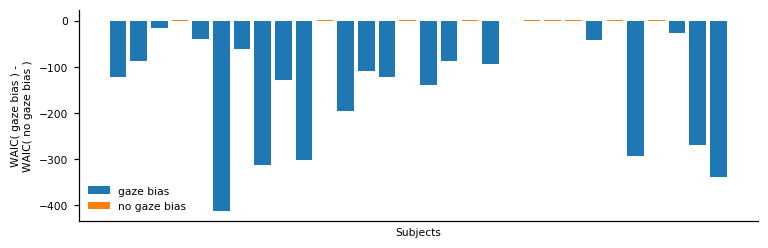

In [28]:
fig, ax = plt.subplots(1, 1, figsize=gb.plots._plots_internal.cm2inch(18,6), dpi=110)

ax.bar(subjects[gaze_bias_idx], dWAIC[gaze_bias_idx], color='C0', label='gaze bias')
ax.bar(subjects[no_gaze_bias_idx], dWAIC[no_gaze_bias_idx], color='C1', label='no gaze bias')
ax.set_xlabel('Subjects', fontsize=7)
ax.set_ylabel('WAIC( gaze bias )'+' -\n'+'WAIC( no gaze bias )', fontsize=7)
ax.legend(loc='lower left', frameon=False, fontsize=7)
ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

fig.savefig('examples/example_1/figures/relative_model_comparison.png', dpi=330)

With this comparison, we are able to identify those participants whose response behaviour matches the assumption of gaze-biased evidence accumulation. In particular, we find that we accurately recover whether an individual has a gaze bias or not for 29 out of 30 individuals.

In [29]:
no_gaze_bias_subjects

array([ 3, 10, 14, 17, 19, 20, 21, 22, 24, 26])

In [30]:
subjects[no_gaze_bias_idx]

array([ 3, 10, 14, 17, 20, 21, 22, 24, 26])

In [31]:
[s in subjects[no_gaze_bias_idx] for s in no_gaze_bias_subjects]

[True, True, True, True, False, True, True, True, True, True]

Looking at the individual parameter estimates (defined as MAP of the posterior distributions), we find that the individually fitted $\gamma$ values cover a wide range between -0.8 and 1 (A), indicating strong variability in the strength of individuals' gaze bias. We also find that $\gamma$ estimates have a strong negative correlation with individuals' scores on the behavioural gaze bias measure (B).

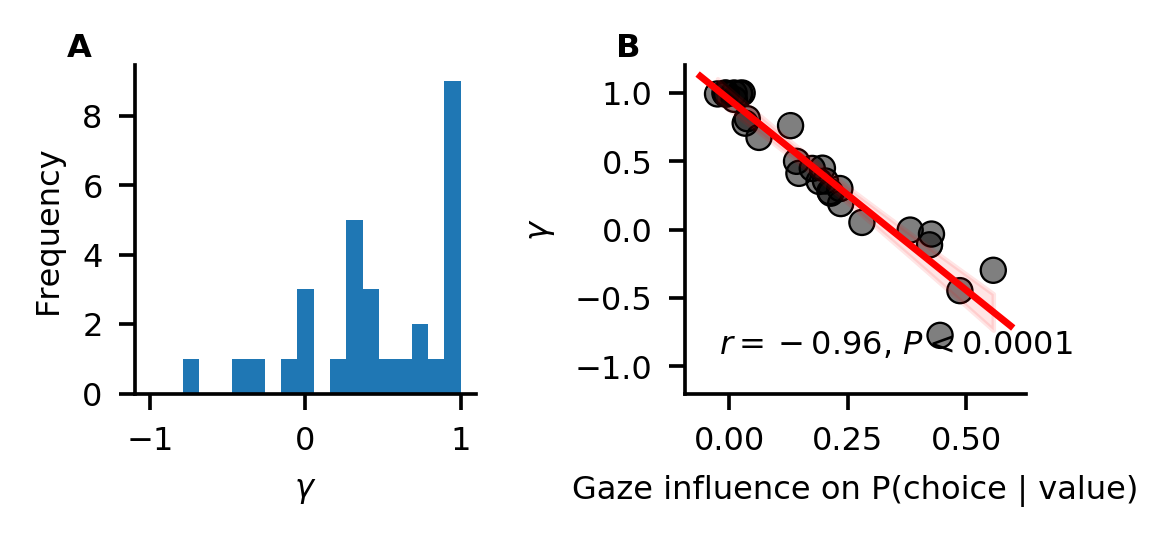

In [34]:
np.random.seed(10)

fig, axs = plt.subplots(1, 2, figsize=gb.plots._plots_internal.cm2inch(9, 4.5), dpi=330)

axs[0].hist(glam_bias.estimates['gamma'], bins=np.linspace(-1., 1, 20))
gb.plots._plots_internal.plot_correlation(subject_data_summary['gaze_influence'],
                          glam_bias.estimates['gamma'],
                          ax=axs[1],
                          ylim=(-1.2, 1.2))

axs[0].set_ylabel('Frequency', fontsize=7)
axs[0].set_xlabel(r'$\gamma$', fontsize=7)
axs[0].tick_params(axis='both', which='major', labelsize=7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].set_ylabel(r'$\gamma$', fontsize=7)
axs[1].set_xlabel('Gaze influence on P(choice | value)', fontsize=7)
axs[1].tick_params(axis='both', which='major', labelsize=7)
for ax, label in zip(axs.ravel(), list('AB')):
    ax.text(-0.2,
            1.1,
            label,
            transform=ax.transAxes,
            fontsize=7,
            fontweight='bold',
            va='top')

fig.tight_layout()

fig.savefig('examples/example_1/figures/Figure_3_gaze_bias_estimates.png', dpi=330)

### 4. Out-of-sample prediction

We have identified those participants whose response behaviour is better described by a GLAM variant with gaze-bias than one without. Yet, this analysis does not indicate whether the GLAM is a good model of individuals' response behaviour on an absolute level. To test this, we perform an out-of-sample prediction exercise.

We divide the data of each subject into even- and odd-numbered experiment trials and use the data of the even-numbered trials to fit both GLAM variants:

In [35]:
data_even = data[(data['trial']%2)==0].copy()
data_odd = data[(data['trial']%2)!=0].copy()

In [36]:
np.random.seed(11)

glam_bias.exchange_data(data_even)
glam_bias.fit(method='MCMC',
              tune=n_tune,
              draws=n_draws,
              chains=n_chains)

Replaced attached data (9000 trials) with new data (4500 trials)...
Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1290.64draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1309.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1300.43draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1294.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1311.43draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1298.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1295.00draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1302.20draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1298.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1304.15draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1300.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1293.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1291.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1292.09draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1302.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1299.49draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1297.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1302.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1297.33draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1307.26draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1328.15draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1299.94draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1310.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1304.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1298.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1300.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1297.61draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1295.92draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1302.98draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1288.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [37]:
np.random.seed(12)

glam_nobias.exchange_data(data_even)
glam_nobias.fit(method='MCMC',
                tune=n_tune,
                draws=n_draws,
                chains=n_chains)

Replaced attached data (9000 trials) with new data (4500 trials)...
Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1948.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1971.92draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1951.15draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1968.04draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1973.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1963.97draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1986.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1981.61draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1984.35draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1983.64draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1960.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1971.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1970.88draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1955.98draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1974.73draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1976.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1973.73draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1957.15draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1974.88draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1972.80draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:19<00:00, 2031.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1966.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1952.92draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1963.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1975.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1990.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1942.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1962.68draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1944.58draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1976.92draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


Again, we check all parameter traces for convergence, before proceeding further in the anlaysis:

In [38]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'gamma', 'tau'])
        for trace in glam_bias.trace])

True

In [39]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'tau'])
        for trace in glam_nobias.trace])

True

In [40]:
for subject, subject_trace in enumerate(glam_bias.trace):
    gb.plots.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/out_of_sample/traces/sub_{}_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/out_of_sample/traces/sub_{}_gaze_bias_model_trace.csv'.format(subject))

In [41]:
for subject, subject_trace in enumerate(glam_nobias.trace):
    gb.plots.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/out_of_sample/traces/sub_{}_no_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/out_of_sample/traces/sub_{}_no_gaze_bias_model_trace.csv'.format(subject))

We then evaluate the performance of both models in predicting individuals' response behaviour using the MAP estimates and item value and gaze data from the odd-numbered trials. To predict response behaviour for the odd-numbered trials, we use the `predict` method. We repeat every trial 50 times in the prediction (as specified through the `n_repeats` argument) to obtain a stable pattern of predictions:

In [42]:
n_repeats = 50

In [43]:
np.random.seed(13)

glam_bias.exchange_data(data_odd)
glam_bias.predict(n_repeats=n_repeats)
glam_bias.prediction.to_csv('examples/example_1/results/out_of_sample/predictions/gaze_bias_model_predictions.csv')

  0%|          | 0/4500 [00:00<?, ?it/s]

Replaced attached data (4500 trials) with new data (4500 trials)...
Generating predictions for 4500 trials (50 repeats each)...


100%|██████████| 4500/4500 [56:17<00:00,  1.33it/s]


In [44]:
np.random.seed(14)

glam_nobias.exchange_data(data_odd)
glam_nobias.predict(n_repeats=n_repeats)
glam_nobias.prediction.to_csv('examples/example_1/results/out_of_sample/predictions/no_gaze_bias_model_predictions.csv')

  0%|          | 0/4500 [00:00<?, ?it/s]

Replaced attached data (4500 trials) with new data (4500 trials)...
Generating predictions for 4500 trials (50 repeats each)...


100%|██████████| 4500/4500 [55:53<00:00,  1.34it/s]


To determine the absolute fit of both model variants to the data, we plot the individually predicted against the individually observed data on all three behavioural metrics. To do this, we use the `plot_individual_fit` function of the `plots` module. This function takes as input the observed data, as well as a list of the predictions of all model variants that ought to be compared. The argument `prediction_labels` specifies the naming used for each model in the resulting figure. For each model variant, the function creates a row of panels, plotting the observed against the predicted data:

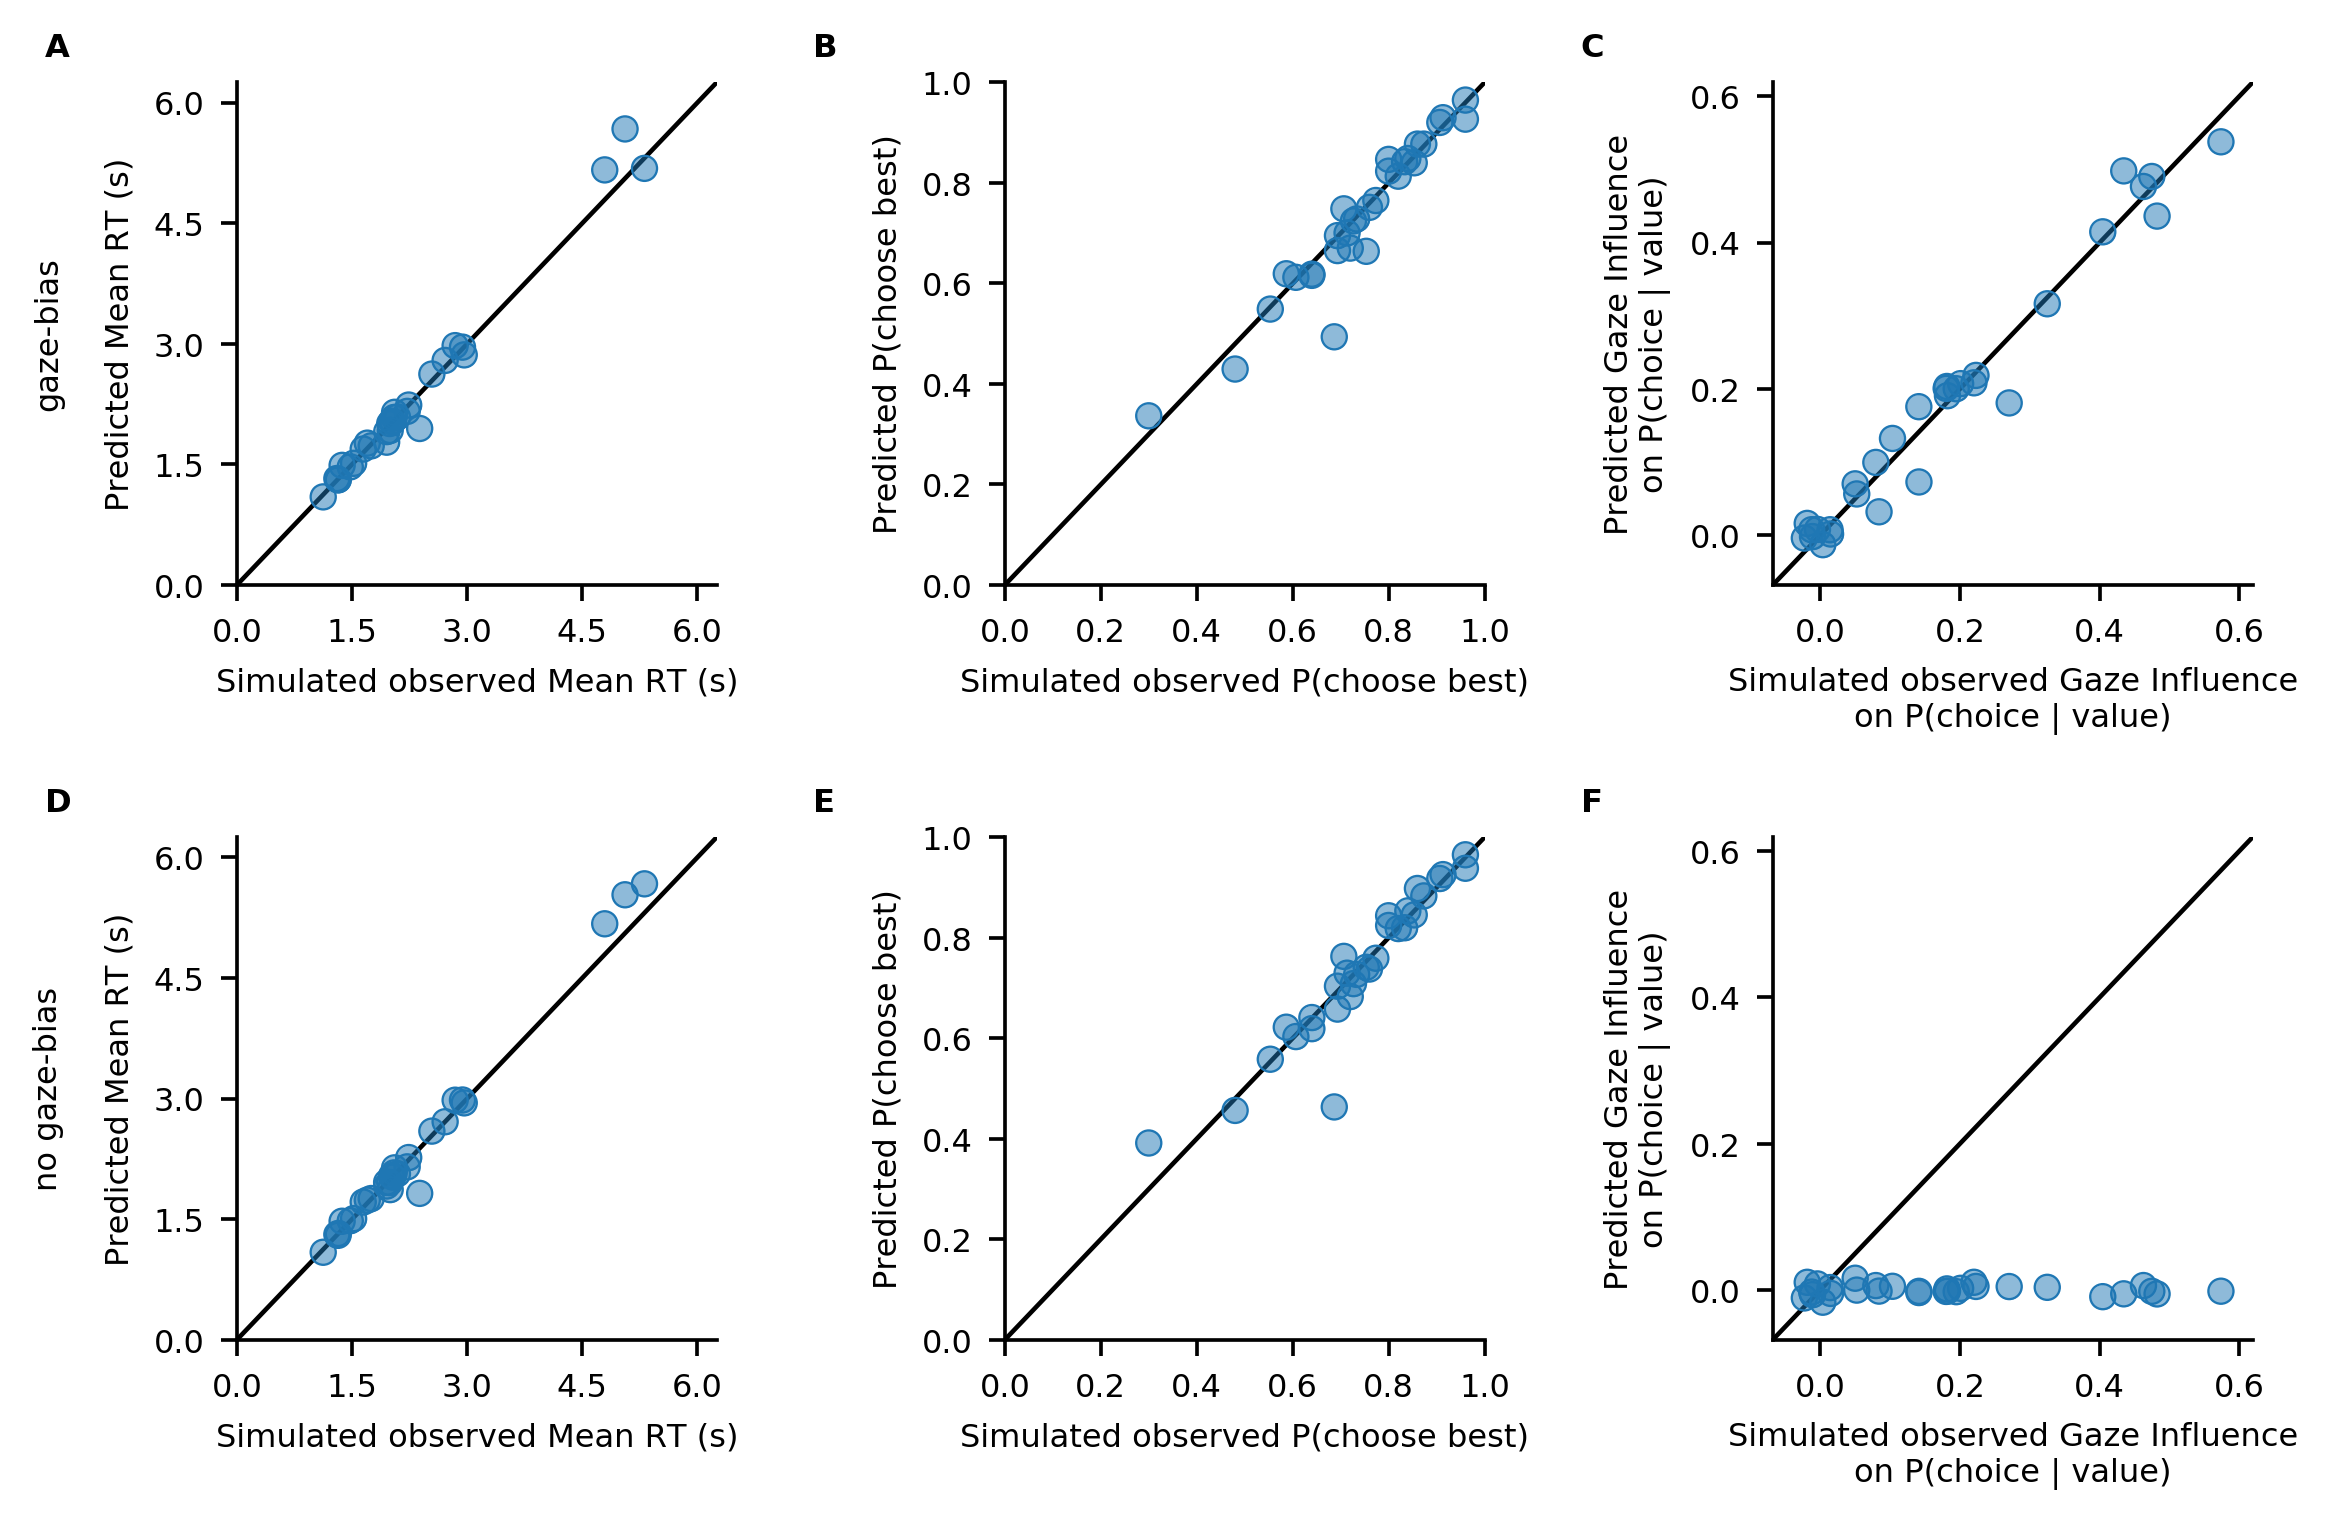

In [45]:
np.random.seed(15)

fig, axs = gb.plots.plot_individual_fit(observed=data_odd,
                                        predictions=[glam_bias.prediction,
                                                     glam_nobias.prediction],
                                        prediction_labels=['gaze-bias', 'no gaze-bias'])

# We'll change the xlabels to "Simulated observed", just to be clear that these are simulated data!
for ax in axs.ravel():
    xlabel = ax.get_xlabel()
    ax.set_xlabel('Simulated o' + xlabel[1:])

fig.savefig('examples/example_1/figures/Figure_4_absolute_fit.png', dpi=330)

Both model variants perform well in capturing individuals' RTs and probability of choosing the best item (A, D, B, E). Importantly, only the GLAM variant with gaze bias is able to also recover the strength of the association between individuals' choice behaviour and gaze allocation (C).

### 5. References:

Thomas, A. W., Molter, F., Krajbich, I., Heekeren, H. R., & Mohr, P. N. (2019). Gaze bias differences capture individual choice behaviour. Nature human behaviour, 3(6), 625.

Vehtari, A., Gelman, A., & Gabry, J. (2017). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and computing, 27(5), 1413-1432.